# Based on what you learned in task 2, to train a neural network model on the BBBP dataset used in HW5 by using Morgan fingerprints as input features and accuracy as the performance measure.   Please do similar explorations as what you did for task 2,  summarize what you have learned from this experiment, and discuss what are similar or different from what you observed in Task 2.  Please  compare your results of you optimal NN model (accuracy) with your optimal random forest model that have been developed in HW5.

In [1]:
!pip install scikit-learn
!pip install rdkit-pypi

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.


In [2]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

In [3]:
# read BBBP.csv file
df = pd.read_csv('BBBP.csv')
df.head()

,num,name,p_np,smiles
0,1,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12
1,2,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl
2,3,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...
3,4,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C
4,5,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...


In [4]:
# define function to calculate morgan fingerprints
Morgan_fpts = []
p_np = []
for i in range(len(df)):
    mol = Chem.MolFromSmiles(df['smiles'][i])
    if mol != None:
        Morgan_fpts.append(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024))
        p_np.append(df['p_np'][i])

[15:47:18] Explicit valence for atom # 1 N, 4, is greater than permitted
[15:47:18] WARNING: not removing hydrogen atom without neighbors
[15:47:18] Explicit valence for atom # 6 N, 4, is greater than permitted
[15:47:18] WARNING: not removing hydrogen atom without neighbors
[15:47:19] WARNING: not removing hydrogen atom without neighbors
[15:47:19] WARNING: not removing hydrogen atom without neighbors
[15:47:19] WARNING: not removing hydrogen atom without neighbors
[15:47:19] WARNING: not removing hydrogen atom without neighbors
[15:47:19] WARNING: not removing hydrogen atom without neighbors
[15:47:19] Explicit valence for atom # 6 N, 4, is greater than permitted
[15:47:19] WARNING: not removing hydrogen atom without neighbors
[15:47:19] WARNING: not removing hydrogen atom without neighbors
[15:47:19] WARNING: not removing hydrogen atom without neighbors
[15:47:19] WARNING: not removing hydrogen atom without neighbors
[15:47:19] Explicit valence for atom # 11 N, 4, is greater than pe

In [5]:
# convert fingerprints to numpy array
Morgan_fpts = np.array(Morgan_fpts)

# convert p_np to numpy array
p_np = np.array(p_np)

In [6]:
# develop and train neural network using the morgan fingerprints
!pip install torch

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/apps/python/3.8.6/intel/bin/python -m pip install --upgrade pip' command.


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [8]:
# standardize the features
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

X_train_norm = (Morgan_fpts - np.mean(Morgan_fpts, axis=0)) / np.std(Morgan_fpts, axis=0)
X_train_norm = torch.from_numpy(X_train_norm)
y_train = torch.from_numpy(p_np)
train_ds = TensorDataset(X_train_norm, y_train)
batch_size = 1
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [9]:
# split data into train, valid, and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Morgan_fpts, p_np, test_size=1./3, random_state=1)

In [10]:
# print length of each set
print("Training set size: ", len(X_train))
print("Test set size: ", len(X_test))

Training set size:  1359
Test set size:  680


In [11]:
# construct neural network 
# use morgan fingerprints as input and accuracy as performance metric
# use sigmoid activation function
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.ReLU()
    def forward(self, x):
        x = self.fc1(x)
        x = self.sigmoid(x)
        x = self.fc2(x)
        return x

In [12]:
input_size = X_train_norm.shape[1]
hidden_size = 32
output_size = 3
model = Net(input_size, hidden_size, output_size)

In [13]:
# use binary cross-entropy as loss function
# use Adam optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
# train model using training set
epochs = 10
losses = []
for epoch in range(epochs):
    for batch in train_dl:
        X_train, y_train = batch
        optimizer.zero_grad()
        y_pred = model(X_train.float())
        loss = loss_fn(y_pred, y_train.long())
        loss.backward()
        optimizer.step()
    losses.append(loss.item())
    print("Epoch: ", epoch, "Loss: ", loss.item())

Epoch:  0 Loss:  0.008580365218222141
Epoch:  1 Loss:  0.0010992205934599042
Epoch:  2 Loss:  0.0014381790533661842
Epoch:  3 Loss:  4.887569048150908e-06
Epoch:  4 Loss:  5.769562994828448e-05
Epoch:  5 Loss:  1.2636104656849056e-05
Epoch:  6 Loss:  5.960462772236497e-07
Epoch:  7 Loss:  1.0490362910786644e-05
Epoch:  8 Loss:  0.016138164326548576
Epoch:  9 Loss:  0.0


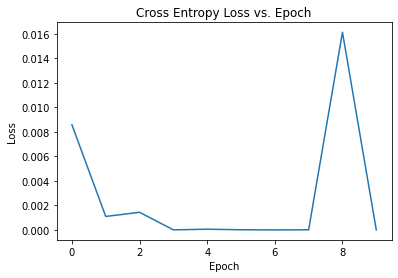

In [15]:
# plot loss vs. epoch
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Cross Entropy Loss vs. Epoch')
plt.show()

In [16]:
# print accuracy score
from sklearn.metrics import accuracy_score

y_pred = model(X_train_norm.float())
y_pred = y_pred.detach().numpy()
y_pred = np.argmax(y_pred, axis=1)
print("Accuracy: ", accuracy_score(p_np, y_pred)*100, '%')

Accuracy:  98.92103972535557 %


In [17]:
# create a neural network with 4 hidden layers
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.ReLU()
    def forward(self, x):
        x = self.fc1(x)
        x = self.sigmoid(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        x = self.fc4(x)
        x = self.sigmoid(x)
        x = self.fc5(x)
        return x

In [18]:
input_size = X_train_norm.shape[1]
hidden_size = 64
output_size = 3
model = Net(input_size, hidden_size, output_size)

In [19]:
# use binary cross-entropy as loss function
# use Adam optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [20]:
# train model using training set
epochs = 10
losses = []
for epoch in range(epochs):
    for batch in train_dl:
        X_train, y_train = batch
        optimizer.zero_grad()
        y_pred = model(X_train.float())
        loss = loss_fn(y_pred, y_train.long())
        loss.backward()
        optimizer.step()
    losses.append(loss.item())
    print("Epoch: ", epoch, "Loss: ", loss.item())

Epoch:  0 Loss:  0.07308977842330933
Epoch:  1 Loss:  0.005136388819664717
Epoch:  2 Loss:  0.03608434274792671
Epoch:  3 Loss:  0.4967205822467804
Epoch:  4 Loss:  8.225102646974847e-05
Epoch:  5 Loss:  0.0002892790944315493
Epoch:  6 Loss:  0.0101386783644557
Epoch:  7 Loss:  0.0
Epoch:  8 Loss:  6.103329360485077e-05
Epoch:  9 Loss:  1.5497195136049413e-06


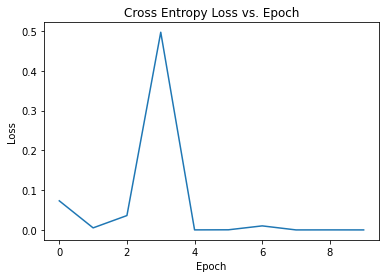

In [21]:
# plot loss vs. epoch
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Cross Entropy Loss vs. Epoch')
plt.show()

In [22]:
# print accuracy score
y_pred = model(X_train_norm.float())
y_pred = y_pred.detach().numpy()
y_pred = np.argmax(y_pred, axis=1)
print("Accuracy: ", accuracy_score(p_np, y_pred)*100, '%')

Accuracy:  98.62677783227072 %


In [23]:
# create a neural network with 2 hidden layers
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.ReLU()
    def forward(self, x):
        x = self.fc1(x)
        x = self.sigmoid(x)
        x = self.fc2(x)
        return x

In [24]:
input_size = X_train_norm.shape[1]
hidden_size = 64
output_size = 3
model = Net(input_size, hidden_size, output_size)

In [25]:
# use binary cross-entropy as loss function
# use Adam optimizer but increase learning rate to 0.01
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [26]:
# train model using training set
epochs = 10
losses = []
for epoch in range(epochs):
    for batch in train_dl:
        X_train, y_train = batch
        optimizer.zero_grad()
        y_pred = model(X_train.float())
        loss = loss_fn(y_pred, y_train.long())
        loss.backward()
        optimizer.step()
    losses.append(loss.item())
    print("Epoch: ", epoch, "Loss: ", loss.item())

Epoch:  0 Loss:  28.704557418823242
Epoch:  1 Loss:  0.8325273394584656
Epoch:  2 Loss:  0.7107309103012085
Epoch:  3 Loss:  0.0
Epoch:  4 Loss:  0.0
Epoch:  5 Loss:  0.0
Epoch:  6 Loss:  0.0
Epoch:  7 Loss:  0.0
Epoch:  8 Loss:  0.0
Epoch:  9 Loss:  0.0


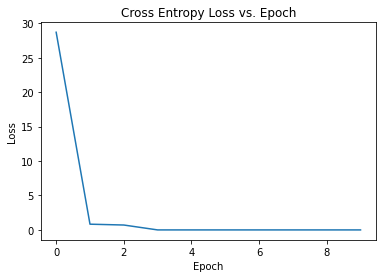

In [27]:
# plot loss vs. epoch
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Cross Entropy Loss vs. Epoch')
plt.show()

In [28]:
# print accuracy score
y_pred = model(X_train_norm.float())
y_pred = y_pred.detach().numpy()
y_pred = np.argmax(y_pred, axis=1)
print("Accuracy: ", accuracy_score(p_np, y_pred)*100, '%')

Accuracy:  93.7224129475233 %


# It appears that increasing learning rate once again decreases the accuracy. This is because when the learning rate is increased, it may cause the optimization algorithm to overshoot the optimal weights/biases. Thus, it may be possible that the algorithm may miss the local minimum or even diverge because of larger steps taken.

In [29]:
# create a neural network with 3 hidden layers
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.fc1(x)
        x = self.sigmoid(x)
        x = self.fc2(x)
        return x
    
input_size = X_train_norm.shape[1]
hidden_size = 32
output_size = 3
model = Net(input_size, hidden_size, output_size)

# use binary cross-entropy as loss function
# use Adam optimizer but decrease learning rate to 0.0001
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# train model using training set
epochs = 10
losses = []
for epoch in range(epochs):
    for batch in train_dl:
        X_train, y_train = batch
        optimizer.zero_grad()
        y_pred = model(X_train.float())
        loss = loss_fn(y_pred, y_train.long())
        loss.backward()
        optimizer.step()
    losses.append(loss.item())
    print("Epoch: ", epoch, "Loss: ", loss.item())

Epoch:  0 Loss:  0.17592987418174744
Epoch:  1 Loss:  0.1562422215938568
Epoch:  2 Loss:  0.13905221223831177
Epoch:  3 Loss:  0.0157676599919796
Epoch:  4 Loss:  0.016667403280735016
Epoch:  5 Loss:  0.02433943562209606
Epoch:  6 Loss:  0.006933912634849548
Epoch:  7 Loss:  0.04385199025273323
Epoch:  8 Loss:  0.02616342157125473
Epoch:  9 Loss:  0.017542092129588127


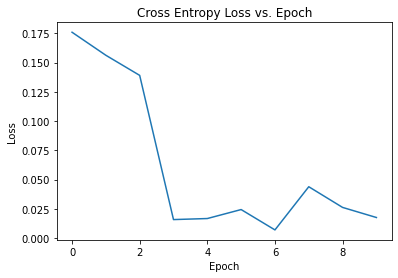

In [30]:
# plot loss vs. epoch
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Cross Entropy Loss vs. Epoch')
plt.show()

In [31]:
# print accuracy score
y_pred = model(X_train_norm.float())
y_pred = y_pred.detach().numpy()
y_pred = np.argmax(y_pred, axis=1)
print("Accuracy: ", accuracy_score(p_np, y_pred))

Accuracy:  0.9671407552721922


# Decreasing the learning rate to 0.0001 performs better than 0.01 but still slightly worse than if the learning rate was set to 0.001. This may be due to the fact that if the learning rate is too slow, the algorithm may get stuck at a local minimum, preventing it from finding the most optimal solution.

# Based on the results, the best learning rate for this binary classification problem would be lr=0.001.

In [34]:
# compare with random forest model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=1)
rf.fit(X_train, y_train)
pred_test = rf.predict(X_test)
print('Accuracy: ', roc_auc_score(y_test, pred_test))

Accuracy:  0.5


# As seen from above, when using a random forest classifier, the neural network performs significantly better.